# Tweet Sentiment Extraction

https://www.kaggle.com/competitions/tweet-sentiment-extraction/overview

## Imports

In [52]:
#Imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# import xgboost as xgb
# from tqdm import tqdm

# stop_words = stopwords.words('english')


from sklearn.svm import SVC
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from nltk import word_tokenize
from nltk.corpus import stopwords
import string
from collections import Counter
import re
import nltk
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn import svm
import warnings
warnings.filterwarnings("ignore")

## Pre Processing

In [30]:
#Importing dataset

test_df = pd.read_csv('test.csv')
train_df = pd.read_csv('train.csv')

In [31]:
train_df.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [32]:
#Checking Training set's size
train_df.shape

(27481, 4)

In [33]:
#Checking types of datasets
print(train_df.dtypes)
print("\n")
print(test_df.dtypes)

textID           object
text             object
selected_text    object
sentiment        object
dtype: object


textID       object
text         object
sentiment    object
dtype: object


In [34]:
#Printing info about each column to get an understanding of the dataset

for column in train_df.columns:
    print(train_df[column].describe())
    print("\n----------------------------\n")

count          27481
unique         27481
top       cb774db0d1
freq               1
Name: textID, dtype: object

----------------------------

count                                    27480
unique                                   27480
top        I`d have responded, if I were going
freq                                         1
Name: text, dtype: object

----------------------------

count     27480
unique    22463
top        good
freq        199
Name: selected_text, dtype: object

----------------------------

count       27481
unique          3
top       neutral
freq        11118
Name: sentiment, dtype: object

----------------------------



In [35]:
#Checking for null-values

print("Train Data:\n")
print(train_df.isnull().any())
print("\nTest Data:\n")
print(test_df.isnull().any())

#We have null values in both the text and selected_text column


Train Data:

textID           False
text              True
selected_text     True
sentiment        False
dtype: bool

Test Data:

textID       False
text         False
sentiment    False
dtype: bool


In [36]:
#Checking how many null-values there are

#Training set
print(train_df.isnull().sum())

#Test set
print(test_df.isnull().sum())

#We only have 1 null value in each of the columns


textID           0
text             1
selected_text    1
sentiment        0
dtype: int64
textID       0
text         0
sentiment    0
dtype: int64


In [37]:
#Checking the amount of tweets with each sentiment

train_df['sentiment'].value_counts()

sentiment
neutral     11118
positive     8582
negative     7781
Name: count, dtype: int64

<Axes: xlabel='sentiment', ylabel='count'>

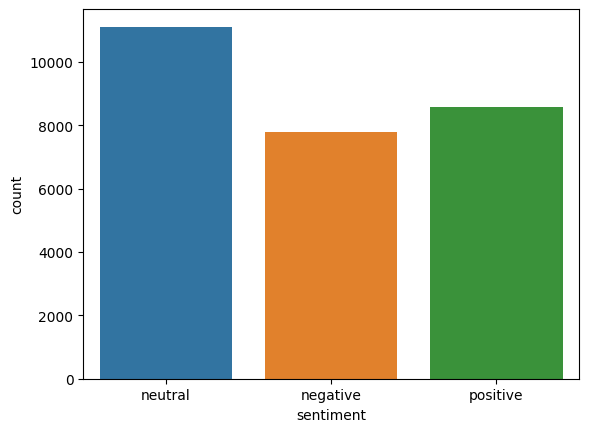

In [38]:
#Creating plot of amount
sns.countplot(x='sentiment', data= train_df)

#We see that we have most neutral sentiments

In [43]:
#Combining the test and trainset, turning sentiment into numerical value

test_df.reset_index(drop=True,inplace=True)
train_df.reset_index(drop=True,inplace=True)
df = pd.concat([train_df,test_df], axis=0)

df.drop(['textID', 'selected_text'], axis=1, inplace=True)
df.sentiment = df.sentiment.map({"neutral":0 ,"positive":1,"negative":-1})

df

,text,sentiment
0,"I`d have responded, if I were going",0
1,Sooo SAD I will miss you here in San Diego!!!,-1
2,my boss is bullying me...,-1
3,what interview! leave me alone,-1
4,"Sons of ****, why couldn`t they put them on t...",-1
...,...,...
3529,"its at 3 am, im very tired but i can`t sleep ...",-1
3530,All alone in this old house again. Thanks for...,1
3531,I know what you mean. My little dog is sinkin...,-1
3532,_sutra what is your next youtube video gonna b...,1


In [53]:
#Removing stop words
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def data_preprocessing(text):
    text = text.lower()
    text = re.sub('<.*?>', '', text) 
    text = ''.join([c for c in text if c not in string.punctuation])
    text = [word for word in text.split() if word not in stop_words]
    text = ' '.join(text)
    return text

df['text'] = df['text'].astype(str).apply(data_preprocessing)

df.head()


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/marcus/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,text,sentiment
0,id responded going,0
1,sooo sad miss san diego,-1
2,boss bullying,-1
3,interview leave alone,-1
4,sons couldnt put releases already bought,-1


In [54]:
#Splitting dataset into training and test

X_train, X_test, y_train, y_test = train_test_split(df.text, df.sentiment, test_size=0.2, random_state=1)

In [55]:
y_train = y_train.astype('int')
y_test= y_test.astype('int')

In [56]:
print(X_train.shape)
print(X_test.shape)

(24812,)
(6203,)


## Model using TF-IDF and Count Vectorizer

TF-IDF

In [57]:
tfv = TfidfVectorizer(min_df=3,  max_features=None, 
            strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), use_idf=1,smooth_idf=1,sublinear_tf=1)

tfv.fit(list(X_train) + list(X_test))
xtrain_tfv =  tfv.transform(X_train) 
xvalid_tfv = tfv.transform(X_test)

Count Vectorizer

In [58]:
ctv = CountVectorizer(analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3))


ctv.fit(list(X_train) + list(X_test))
xtrain_ctv =  ctv.transform(X_train) 
xvalid_ctv = ctv.transform(X_test)

Logistic Regression

In [59]:
clf = LogisticRegression(random_state=0, multi_class='multinomial')
clf.fit(xtrain_tfv, y_train)

LogisticRegression(multi_class='multinomial', random_state=0)

In [60]:
#Testing Logistic Regression with TF-IDF:

val_pred = clf.predict(xvalid_tfv)
print("The accurary of logistic regression with tf-idf embedding is",accuracy_score(list(y_test), val_pred))

The accurary of logistic regression with tf-idf embedding is 0.6903111397710785


In [61]:
#Testing Logistic Regression with Count Vectorizer:

clf = LogisticRegression(random_state=0, multi_class='multinomial')
clf.fit(xtrain_ctv, y_train)
val_pred = clf.predict(xvalid_ctv)
print("The accurary of logistic regression with count-vectorizer embedding is",accuracy_score(list(y_test), val_pred))

The accurary of logistic regression with count-vectorizer embedding is 0.6999838787683379


## Exporting predictions to .csv

In [62]:
predict = pd.DataFrame(val_pred)

predict_file = predict.to_csv("submission.csv", index=False)